## Using the  Super Resolution convolutional Neural Network for Image Restoration 
We propose a depp learning method for single image super resolution(SR). Our method directly learns an end-to end mapping between the low/high resolution images. The mapping is represented as a deep convolutional neural network (CNN) that takes the low-resolution image as the input and outputs the high-resolution one. We further show that traditional sparse-coding-based SR methods can also be viewed as a deep convolutional network. But unlike traditional methods that handle each component separately, our method jointly optimizes all layers. Our deep CNN has a lightweight structure. yet demonstrates state-of-the-art restoration quality, and achieves fast speed for practical on-line usage. We explore different network structures and parameter settings to achieve trade-offs between performance and speed. Moreover, we extend our network to cope with three color channels simultaneously, and show
better overall reconstruction quality.

As the title suggests the SRCNN is a deep convolutiorul neural network that learns end-to-end mapping of low resolution to high resolution images As a result we can use it to improve image quality of low resolution images. To evaluate the performance of this network. we will be using three image quality metrics: peak signal to noise ratio (PSNR) means squared error (MSE), and the structural similarity (SSIM) index.


1. Use the PSNR, MSE and SSIM image quality metrics
2. process image using OpenCv
3. convert between the RGB, BGR and YcrCb color spaces
4. build deep neural networks in Keras
5. deploy and evaluate the SRCNN network

In [48]:
from keras.models import Sequential
from keras.layers import Conv2D, Input
from keras.optimizers import SGD, Adam
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os

In [49]:
# define a function for peak signal to noise ration (PSNR)

def psnr(target, ref):
    target_data = target.astype(float)
    ref_data = ref.astype(float)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    rmse = math.sqrt(np.mean(diff **2.))
    return 20 * math.log10(255./rmse)

def mse(target, ref):
    err = np.sum((target.astype('float')- ref.astype('float'))**2)
    err /= float(target.shape[0]*target.shape[1])
    return err

def compare_image(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, win_size=3, channel_axis=-1)) 
    return scores

In [50]:
def prepare_images(path, factor):
    # loop thrught the files in the directory
    for file in os.listdir(path):
        # open the file
        image = cv2.imread(path + '/' + file)
        # find the old and new image dimensions
        h, w, c = image.shape
        new_h, new_w = int(h / factor), int(w /factor)
        # resize the image - down
        image = cv2.resize(image, (new_w, new_h), interpolation= cv2.INTER_LINEAR)
        # resize the image - up
        image = cv2.resize(image, (w, h), interpolation = cv2.INTER_LINEAR)
        # save he image
        print("Saving {}".format(file))
        output_dir = 'data/degraded'
        os.makedirs(output_dir, exist_ok=True) 
        output_path = os.path.join(output_dir, file)
        cv2.imwrite(output_path, image)
        
        

In [51]:
prepare_images('data/test/', 4)

Saving IM-0001-0001.jpeg
Saving IM-0003-0001.jpeg
Saving IM-0005-0001.jpeg
Saving IM-0006-0001.jpeg
Saving IM-0007-0001.jpeg
Saving IM-0009-0001.jpeg
Saving IM-0010-0001.jpeg
Saving IM-0011-0001-0001.jpeg
Saving IM-0011-0001-0002.jpeg
Saving IM-0011-0001.jpeg
Saving IM-0013-0001.jpeg
Saving IM-0015-0001.jpeg


In [52]:
# testing the generated images using the image quality metrics

for file in os.listdir('data/test/'):
    target = cv2.imread('data/degraded/{}'.format(file))
    ref = cv2.imread('data/test/{}'.format(file))
    
    # calculate the scores
    scores = compare_image(target, ref)
    print(f"{file} \nPSNR: {scores[0]}\n MSE : {scores[1]}\nSSIM : {scores[2]}")

IM-0001-0001.jpeg 
PSNR: 33.95341775453211
 MSE : 78.49822563887427
SSIM : 0.8717499042299833
IM-0003-0001.jpeg 
PSNR: 35.45114287756962
 MSE : 55.60160496047872
SSIM : 0.8675117615591582
IM-0005-0001.jpeg 
PSNR: 33.45605159584047
 MSE : 88.02305875693222
SSIM : 0.8487773076013397
IM-0006-0001.jpeg 
PSNR: 31.903048447492395
 MSE : 125.86262084277719
SSIM : 0.8415423610392857
IM-0007-0001.jpeg 
PSNR: 34.02429855719678
 MSE : 77.22746154303691
SSIM : 0.8537071238703846
IM-0009-0001.jpeg 
PSNR: 31.377156756543783
 MSE : 142.06462194043186
SSIM : 0.7767360576248169
IM-0010-0001.jpeg 
PSNR: 33.675060144885414
 MSE : 83.69424598687856
SSIM : 0.8458244542748936
IM-0011-0001-0001.jpeg 
PSNR: 34.14243384940919
 MSE : 75.15506082907487
SSIM : 0.8483803779565332
IM-0011-0001-0002.jpeg 
PSNR: 34.97832198817986
 MSE : 61.996820420646365
SSIM : 0.8832557273246283
IM-0011-0001.jpeg 
PSNR: 32.836890955130286
 MSE : 101.51086302475902
SSIM : 0.792433842079539
IM-0013-0001.jpeg 
PSNR: 33.70654050279966


In [53]:
target.shape

(1238, 1803, 3)

In [54]:
ref.shape

(1238, 1803, 3)

In [55]:
# define the SRCNN model
def model():
    # define model type
    SRCNN = Sequential()
    # add model layers
    SRCNN.add(Conv2D(filters = 128, kernel_size=  (9,9), kernel_initializer= 'glorot_uniform', activation = 'relu', padding = 'valid', use_bias = True, input_shape = (None, None, 1)))   
    SRCNN.add(Conv2D(filters = 64, kernel_size = (3,3), kernel_initializer='glorot_uniform', activation = 'relu', padding = 'same', use_bias = True))
    SRCNN.add(Conv2D(filters = 1, kernel_size = (5, 5), kernel_initializer='glorot_uniform', activation = 'linear', padding = 'valid', use_bias = True))
    
    # define optimizer
    adam = Adam(learning_rate=0.0003)
    
    SRCNN.compile(optimizer = adam, loss= 'mean_squared_error', metrics = ['mean_squared_error'])
    return SRCNN

In [56]:
# define necessary image processing functions
def modcrop(img, scale):
    h, w = img.shape[:2]
    h = h - (h % scale)  # Ensure divisibility
    w = w - (w % scale)
    return img[:h, :w]


def shave(image, border):
    img = image[border : -border, border : -border]
    return img
    

In [57]:
# define main predication function
def predict(image_path):
    srcnn = model()
    srcnn.load_weights('srcnn_trained.weights.h5')
    
    # load the degraded and refernce images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread(f'original/{file}')
    
    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    #convert the image to YCrCb (red diff, blue diff) - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize
    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype = float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size = 1)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    #copy Y channel back tom image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    # remove border from reference and degraded image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
    scores.append(compare_image(degraded, ref))
    scores.append(compare_image(output, ref))
    
    return ref, degraded, output, scores

In [ ]:
ref, degraded, output, scores = predict('degraded/NORMAL2-IM-0221-0001.jpeg')
print(f"Degraded Image : \nPSNR: {scores[0][0]}\n MSE : {scores[0][1]}\nSSIM : {scores[0][2]}")
print(f"Reconstructed Image : \nPSNR: {scores[1][0]}\n MSE : {scores[1][1]}\nSSIM : {scores[1][2]}")


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


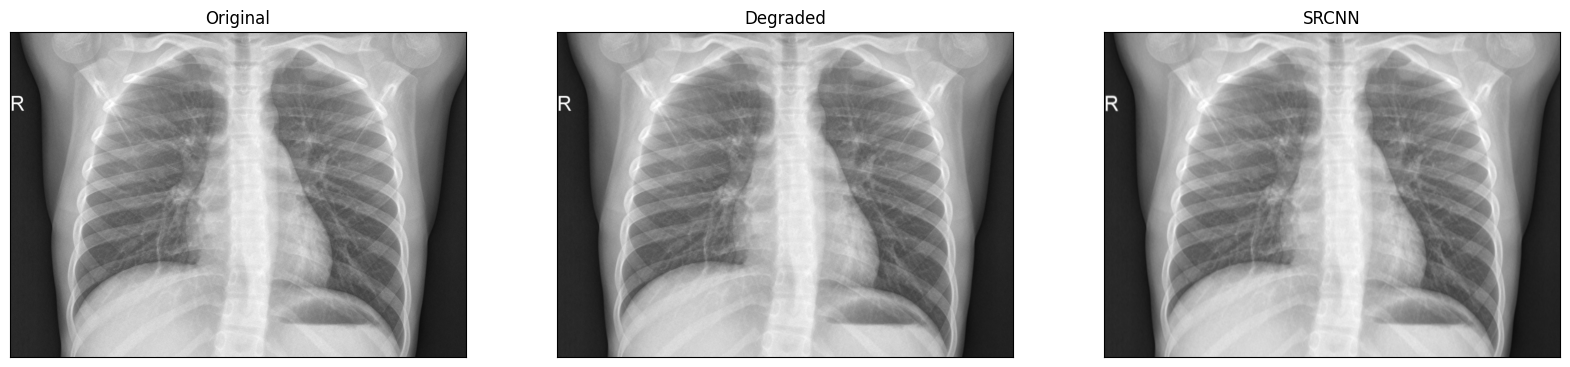

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')

axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    

In [ ]:
for file in os.listdir('data/test'):
    ref, degraded, output, scores = predict(f'data/test/{file}')
    fig, axs = plt.subplots(1, 3, figsize = (20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = f'Degraded Image : \nPSNR: {scores[0][0]}\n MSE : {scores[0][1]}\nSSIM : {scores[0][2]}')
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = f'Degraded Image : \nPSNR: {scores[0][0]}\n MSE : {scores[0][1]}\nSSIM : {scores[0][2]}')
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
    
    #save the images
    print(f"Saving the {file}")
    fig.savefig(f'output/{os.path.splitext(file)[0]}.png')
    plt.close()

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
